In [460]:
import numpy as np
import random
from functools import reduce
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.quantum_info import Statevector
from scipy.linalg import expm
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

## Global Constants

In [444]:
# Pauli Matrices
X = np.array([[0, 1],
              [1, 0]], dtype=complex)
Y = np.array([[0, -1j],
              [1j,  0]], dtype=complex)
Z = np.array([[1, 0],
              [0, -1]], dtype=complex)
I = np.eye(2, dtype=complex)

# Problem parameters
N = 10            # number of qubits
t = 1.0           # total evolution time
n_samples = 100   # size of dataset
k = 3             # number of 3-local Pauli observables

# Simulator
simulator = AerSimulator()

# Sweep defaults
trotter_list = [2, 4, 8, 16, 32, 64, 128, 254]
shots_list   = [10, 100, 1000, 5000, 10000, 20000, 50000]

# Fidelity target
fid_target = 0.95

## Helper Functions

In [445]:
# Generate random coupling matrix J
def generate_J(N, low=0.0, high=2.0):
    """
    Generate a symmetric NxN coupling matrix J where for i<j: J[i,j] = J[j,i] ~ Uniform(low, high) and J[i,i] = 0.
    """
    J = np.zeros((N, N), dtype=float)
    for i in range(N):
        for j in range(i + 1, N):
            val = np.random.uniform(low, high)
            J[i, j] = val
            J[j, i] = val
    return J

# Build all-to-all Heisenberg Hamiltonian
def build_heisenberg_hamiltonian(J):
    """
    Given an NxN coupling matrix J, construct the full 2^N by 2^N Heisenberg Hamiltonian H = sum_{i<j} J[i,j] * (X_i X_j + Y_i Y_j + Z_i Z_j)
    """
    dim = 2 ** J.shape[0]
    H = np.zeros((dim, dim), dtype=complex)
    for i in range(J.shape[0]):
        for j in range(i + 1, J.shape[0]):
            coupling = J[i, j]
            for P in (X, Y, Z):
                ops = [I] * N
                ops[i] = P
                ops[j] = P
                H += coupling * reduce(np.kron, ops)
    return H

# Build 1D nearest‐neighbour Heisenberg chain Hamiltonian
def build_chain_heisenberg(N, Jval=1.0, periodic=True):
    """
    Construct H = sum_{i~j} Jval * (X_i X_j + Y_i Y_j + Z_i Z_j) on a 1D chain of length N.
    If periodic=True, include bond (N-1,0); otherwise open chain.
    """
    # build J matrix for nearest neighbours
    J = np.zeros((N, N))
    for i in range(N - 1):
        J[i, i+1] = J[i+1, i] = Jval
    if periodic:
        J[N-1, 0] = J[0, N-1] = Jval

    # reuse the all‐to‐all builder
    return build_heisenberg_hamiltonian(J)

# Build Transverse‐Field Ising Model (TFIM) Hamiltonian
def build_tfim(J, h):
    """
    Given an NxN symmetric coupling matrix J for ZZ terms and field h, construct H = sum_{i<j} J[i,j] Z_i Z_j  +  h * sum_i X_i.
    """
    dim = 2**J.shape[0]
    H = np.zeros((dim, dim), dtype=complex)

    # ZZ couplings
    for i in range(J.shape[0]):
        for j in range(i+1, J.shape[0]):
            if J[i, j] != 0:
                ops = [I]*N
                ops[i] = Z
                ops[j] = Z
                H += J[i, j] * reduce(np.kron, ops)

    # transverse field
    for i in range(N):
        ops = [I]*N
        ops[i] = X
        H += h * reduce(np.kron, ops)

    return H

# Build XY model Hamiltonian
def build_xy(J):
    """
    Given an NxN symmetric coupling matrix J, construct H = sum_{i<j} J[i,j] ( X_i X_j + Y_i Y_j ).
    """
    dim = 2**J.shape[0]
    H = np.zeros((dim, dim), dtype=complex)

    for i in range(J.shape[0]):
        for j in range(i+1, J.shape[0]):
            if J[i, j] != 0:
                for P in (X, Y):
                    ops = [I]*N
                    ops[i] = P
                    ops[j] = P
                    H += J[i, j] * reduce(np.kron, ops)

    return H

# Parity Hamiltonian
def build_parity_hamiltonian(N):
    """
    Build H = X_1 X_2 ... X_N, whose expectation on |x> gives (-1)^{parity(x)}.
    """
    P = reduce(np.kron, [X]*N)
    # as a Hamiltonian we can just use H = P
    dim = 2**N
    H = np.zeros((dim, dim), dtype=complex)
    H += P
    return H

# Convert bitstring to computational‐basis statevector
def bitstring_to_state(x):
    """
    Convert a binary list or array x of length N into the 2^N‐dimensional computational‐basis statevector |x>.
    """
    n   = len(x)
    dim = 2**n
    state = np.zeros(dim, dtype=complex)
    # compute index from bitstring
    idx = int("".join(str(int(b)) for b in x), 2)
    state[idx] = 1.0
    return state

# Build an N-qubit Pauli string operator
def build_pauli_string(qubits, labels, N):
    """
    Return the 2^N x 2^N matrix for a Pauli string:
      - qubits: list of qubit indices where you apply non-identity
      - labels: list of 'X', 'Y', or 'Z' of the same length
      - N: total number of qubits
    All other positions get the identity.
    """
    pauli_map = {'X': X, 'Y': Y, 'Z': Z}
    ops = [I] * N
    for q, lab in zip(qubits, labels):
        ops[q] = pauli_map[lab]
    return reduce(np.kron, ops)

# Build an N-qubit Pauli string operator which acts non-trivially
def sample_useful_pauli_terms(X_bits, U, N, k, var_thresh=1e-3):
    """
    Draw random 3-local Pauli strings until we have k of them whose exact expectation var >= var_thresh over X_bits.
    Returns list of dicts with 'qubits','labels','matrix'.
    """
    useful = []
    while len(useful) < k:
        qs = random.sample(range(N), 3)
        labels = [random.choice(['X','Y','Z']) for _ in range(3)]
        P = build_pauli_string(qs, labels, N)
        feats  = []
        for x in X_bits:
            psi = U @ bitstring_to_state(x)
            feats.append(np.vdot(psi, P @ psi).real)
        feats = np.array(feats)
        if np.var(feats) >= var_thresh:
            useful.append({'qubits':qs, 'labels':labels, 'matrix':P})
    return useful


# Build observable O from sampled Pauli terms and random coefficients
def build_observable(X_bits, U, num_terms, var_thresh=1e-3):
    """
    Sample num_terms “useful” 3-local Pauli terms on N qubits (using X_bits and U),
    draw one coefficient in [0,2) per term, and assemble the observable O.

    Inputs:
      X_bits     – array of shape (n_samples, N) of input bit-strings
      U          – 2^N x 2^N unitary exp(-1j H t)
      num_terms  – number of Pauli terms to include in O
      var_thresh – minimum variance threshold for selecting a term

    Returns:
      pauli_terms – list of num_terms dicts, each with keys: 'qubits', 'labels', 'matrix'
      coeffs      – length-num_terms array of random floats in [0,2)
      O_matrix    – full 2^N x 2^N Hermitian observable sum_j coeffs[j]*P_j
    """
    n_samples, N = X_bits.shape

    # sample the Pauli terms
    pauli_terms = sample_useful_pauli_terms(X_bits, U, N, num_terms, var_thresh)

    # draw random coefficients
    coeffs = np.random.uniform(0.0, 2.0, size=num_terms)

    # assemble O = sum_j coeffs[j]*P_j
    dim = 2**N
    O_matrix = np.zeros((dim, dim), dtype=complex)
    for c, term in zip(coeffs, pauli_terms):
        O_matrix += c * term['matrix']

    return pauli_terms, coeffs, O_matrix

# Compute exact labels y for a given O and U
def compute_labels(X_bits, U, O_matrix):
    """
    For each bitstring x in X_bits, prepare |psi> = U|x>, then compute y = <psi| O_matrix |psi> exactly.

    Inputs:
      X_bits   – array (n_samples, N) of 0/1 bit-strings
      U        – 2^Nx2^N unitary
      O_matrix – 2^Nx2^N observable

    Returns:
      y_values – array of length n_samples
    """
    n_samples = X_bits.shape[0]
    y_values = np.zeros(n_samples)
    for i, x in enumerate(X_bits):
        state = U @ bitstring_to_state(x)
        y_values[i] = np.vdot(state, O_matrix @ state).real
    return y_values

# Compute exact feature matrix for sampled Pauli terms
def compute_exact_features(X_bits, U, pauli_terms):
    """
    Build feature matrix of shape (n_samples, num_terms) where entry (i,j) is <psi_i | P_j | psi_i> with |psi_i> = U|x_i>.

    Inputs:
      X_bits      – array (n_samples, N)
      U           – 2^Nx2^N unitary
      pauli_terms – list of dicts each containing key 'matrix'

    Returns:
      features    – array of shape (n_samples, len(pauli_terms))
    """
    n_samples = X_bits.shape[0]
    num_terms  = len(pauli_terms)
    features   = np.zeros((n_samples, num_terms))
    for i, x in enumerate(X_bits):
        state = U @ bitstring_to_state(x)
        for j, term in enumerate(pauli_terms):
            P = term['matrix']
            features[i, j] = np.vdot(state, P @ state).real
    return features

# Build Trotter circuit for any supported Hamiltonian
def build_trotter_circuit(name, x, J=None, h=None, t=1.0, steps=1024):
    """
    Build a first-order Trotter circuit for exp(-i H t) |x>, where H is:
      - 'all-to-all-heisenberg' or 'chain-heisenberg': sum J[i,j](XX+YY+ZZ)
      - 'tfim': sum J[i,j] ZZ  +  h sum X
      - 'xy': sum J[i,j](XX+YY)
      - 'parity': XX…X
    """
    N = len(x)
    qc = QuantumCircuit(N)
    # prepare basis state |x>
    for i, bit in enumerate(x):
        if bit:
            qc.x(i)
    dt = t / steps

    for _ in range(steps):
        if name in ('all-to-all-heisenberg', 'chain-heisenberg'):
            for i in range(N):
                for j in range(i+1, N):
                    coeff = J[i, j]
                    if coeff == 0:
                        continue
                    theta = coeff * dt
                    # XX
                    qc.h(i); qc.h(j)
                    qc.cx(i, j); qc.rz(2*theta, j); qc.cx(i, j)
                    qc.h(i); qc.h(j)
                    # YY
                    qc.sdg(i); qc.sdg(j)
                    qc.h(i); qc.h(j)
                    qc.cx(i, j); qc.rz(2*theta, j); qc.cx(i, j)
                    qc.h(i); qc.h(j)
                    qc.s(i); qc.s(j)
                    # ZZ
                    qc.cx(i, j); qc.rz(2*theta, j); qc.cx(i, j)

        elif name == 'tfim':
            # ZZ couplings
            for i in range(N):
                for j in range(i+1, N):
                    coeff = J[i, j]
                    if coeff == 0:
                        continue
                    theta = coeff * dt
                    qc.cx(i, j); qc.rz(2*theta, j); qc.cx(i, j)
            # X field
            for i in range(N):
                qc.rx(2 * h * dt, i)

        elif name == 'xy':
            for i in range(N):
                for j in range(i+1, N):
                    coeff = J[i, j]
                    if coeff == 0:
                        continue
                    theta = coeff * dt
                    # XX
                    qc.h(i); qc.h(j)
                    qc.cx(i, j); qc.rz(2*theta, j); qc.cx(i, j)
                    qc.h(i); qc.h(j)
                    # YY
                    qc.sdg(i); qc.sdg(j)
                    qc.h(i); qc.h(j)
                    qc.cx(i, j); qc.rz(2*theta, j); qc.cx(i, j)
                    qc.h(i); qc.h(j)
                    qc.s(i); qc.s(j)

        elif name == 'parity':
            # global X rotation via parity
            for i in range(N-1):
                qc.cx(i, N-1)
            qc.rz(2 * dt, N-1)
            for i in reversed(range(N-1)):
                qc.cx(i, N-1)

        else:
            raise ValueError(f"Unknown Hamiltonian: {name}")

    return qc


# Extract noisy features using the general Trotter‐circuit builder
def extract_features_qasm_general(name, x, J, h, time, steps, pauli_terms, shots=1024):
    """
    Estimate feature vector for bitstring x using QASM and the Trotter circuit.

    Inputs:
      name        – Hamiltonian name string
      x           – 1D array of 0/1 of length N
      J           – NxN coupling matrix (if required)
      h           – TFIM field strength (if required)
      time        – total evolution time
      steps       – number of Trotter slices
      pauli_terms – list of dicts with keys 'qubits' and 'labels'
      shots       – number of measurement shots per term

    Returns:
      phi_q       – 1D numpy array of length len(pauli_terms)
    """
    N = len(x)
    # build the Trotter approximation circuit
    base_qc = build_trotter_circuit(name, x, J=J, h=h, t=time, steps=steps)

    # add measurement registers
    qc = QuantumCircuit(N, N)
    qc.compose(base_qc, inplace=True)

    phi_q = np.zeros(len(pauli_terms))

    # for each Pauli term, rotate and measure
    for idx, term in enumerate(pauli_terms):
        qc_term = qc.copy()
        for q, lab in zip(term['qubits'], term['labels']):
            if lab == 'X':
                qc_term.h(q)
            elif lab == 'Y':
                qc_term.sdg(q)
                qc_term.h(q)
        qc_term.measure(range(N), range(N))

        compiled = transpile(qc_term, simulator)
        result   = simulator.run(compiled, shots=shots).result()
        counts   = result.get_counts()

        exp_val = 0
        for bitstr, cnt in counts.items():
            bits = np.array([int(b) for b in bitstr[::-1]])
            parity = 1
            for q in term['qubits']:
                parity *= (1 - 2 * bits[q])
            exp_val += parity * cnt
        phi_q[idx] = exp_val / shots

    return phi_q


# Sweep Trotter steps and shots to find feature‐fidelity
def sweep_trotter_shots(name, X_bits, J, h, U, pauli_terms, trotter_list, shots_list, subset=20):
    """
    On a random subset of X_bits of size=subset, compute exact features once, then for each (steps,shots) build Phi_noisy and record min Pearson corr.
    Returns a pandas DataFrame with columns ['steps','shots','min_corr'].
    """
    n = X_bits.shape[0]
    k = len(pauli_terms)
    idxs = np.random.choice(n, subset, replace=False)

    # exact features on subset
    Phi_exact = np.zeros((subset, k))
    for i, idx in enumerate(idxs):
        psi = U @ bitstring_to_state(X_bits[idx])
        for j, term in enumerate(pauli_terms):
            Phi_exact[i, j] = np.vdot(psi, term['matrix'] @ psi).real

    records = []
    for steps in trotter_list:
        for shots in shots_list:
            Phi_noisy = np.zeros((subset, k))
            for i, idx in enumerate(idxs):
                # build and run Trotter circuit + measure
                Phi_noisy[i, :] = extract_features_qasm_general(name, X_bits[idx], J, h, t, steps, pauli_terms, shots)
            corrs = [np.corrcoef(Phi_noisy[:,j], Phi_exact[:,j])[0,1]
                     for j in range(k)]
            records.append({
                'steps':   steps,
                'shots':   shots,
                'min_corr': min(corrs)
            })

    return pd.DataFrame(records)

# Build full noisy feature map Phi_q
def build_phi_q(name, X_bits, J, h, t, best_steps, pauli_terms, shots):
    """
    Return Phi_q of shape (n_samples, k) by running extract_features_qasm
    with the optimal steps and shots for each bitstring in X_bits.
    """
    n = X_bits.shape[0]
    k = len(pauli_terms)
    Phi_q = np.zeros((n, k))
    for i, x in enumerate(X_bits):
        # build circuit
        Phi_q[i, :] = extract_features_qasm_general(name, x, J, h, t, best_steps, pauli_terms, shots)
    return Phi_q


# LASSO helper
def run_lasso(phi, y, test_size=0.2, cv=5, alphas=None, random_state=0):
    """
    Split (phi,y) into train/test, fit LassoCV on train, and evaluate.

    Returns a dict with:
      phi_train, phi_test, y_train, y_test,
      model,
      mse_train, mse_test,
      r2_train, r2_test,
      alpha_opt,
      coef
    """
    # split
    phi_train, phi_test, y_train, y_test = train_test_split(
        phi, y, test_size=test_size, random_state=random_state
    )

    # fit
    lasso = LassoCV(alphas=alphas, cv=cv, random_state=random_state)
    lasso.fit(phi_train, y_train)

    # predict
    y_pred_train = lasso.predict(phi_train)
    y_pred_test  = lasso.predict(phi_test)

    # metrics
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test  = mean_squared_error(y_test,  y_pred_test)
    r2_train  = r2_score(y_train, y_pred_train)
    r2_test   = r2_score(y_test,  y_pred_test)

    return {
        'phi_train': phi_train,
        'phi_test':  phi_test,
        'y_train':   y_train,
        'y_test':    y_test,
        'model':     lasso,
        'mse_train': mse_train,
        'mse_test':  mse_test,
        'r2_train':  r2_train,
        'r2_test':   r2_test,
        'alpha_opt': lasso.alpha_,
        'coef':      lasso.coef_,
    }

# NN helper
def run_nn(phi, y, test_size=0.2, hidden_layer_sizes=(50,), activation='relu', solver='adam', alpha=1e-4, batch_size='auto', max_iter=1000, random_state=0):
    """
    Split (phi,y) into train/test, fit MLPRegressor on train, and evaluate.

    Returns a dict with:
      phi_train, phi_test, y_train, y_test,
      model,
      mse_train, mse_test,
      r2_train, r2_test,
      loss_curve
    """
    # split
    phi_train, phi_test, y_train, y_test = train_test_split(
        phi, y, test_size=test_size, random_state=random_state
    )

    # fit on train
    nn = MLPRegressor(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver=solver,
        alpha=alpha,
        batch_size=batch_size,
        max_iter=max_iter,
        random_state=random_state,
        tol=1e-6,
    )
    nn.fit(phi_train, y_train)

    # predict
    y_pred_train = nn.predict(phi_train)
    y_pred_test  = nn.predict(phi_test)

    # metrics
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test  = mean_squared_error(y_test,  y_pred_test)
    r2_train  = r2_score(y_train, y_pred_train)
    r2_test   = r2_score(y_test,  y_pred_test)

    return {
        'phi_train':  phi_train,
        'phi_test':   phi_test,
        'y_train':    y_train,
        'y_test':     y_test,
        'model':      nn,
        'mse_train':  mse_train,
        'mse_test':   mse_test,
        'r2_train':   r2_train,
        'r2_test':    r2_test,
        'loss_curve': nn.loss_curve_,
    }

## Main Pipeline

In [452]:
def run_pipeline(name, X_bits, field_h, num_terms, trotter_list, shots_list, test_size=0.2, random_state=0):
    """
    Executes the full pipeline:
      1) Build J, H, U
      2) Sample Pauli terms and build O
      3) Compute exact labels y
      4) Compute exact features phi_ex
      5) Sweep trotter steps & shots, select minimal steps/shots achieving fid_target
      6) Build noisy features phi_q
      7) Run LASSO and NN on exact and noisy features
      8) Print progress and return all results for later analysis
    """
    print(f"=== PIPELINE START: '{name}' ===")
    # 1) coupling, Hamiltonian, unitary
    print("1) Generating coupling J and Hamiltonian H …")
    J = generate_J(N)
    if name in ('all-to-all-heisenberg', 'chain-heisenberg'):
        H = build_heisenberg_hamiltonian(J)
    elif name == 'tfim':
        H = build_tfim(J, field_h)
    elif name == 'xy':
        H = build_xy(J)
    elif name == 'parity':
        H = build_parity_hamiltonian(N)
    else:
        raise ValueError(f"Unknown Hamiltonian: {name}")
    U = expm(-1j * H * t)
    print("   -> Unitary U computed")

    # 2) sample observable
    print(f"2) Sampling {num_terms} useful Pauli terms and building O …")
    terms, coeffs, O_matrix = build_observable(X_bits, U, num_terms)

    # 3) exact labels
    print("3) Computing exact labels y …")
    y = compute_labels(X_bits, U, O_matrix)
    print(f"   -> y shape: {y.shape}")

    # 4) exact features
    print("4) Computing exact feature matrix phi_ex …")
    phi_ex = compute_exact_features(X_bits, U, terms)
    print(f"   -> phi_ex shape: {phi_ex.shape}")


    #'''
    # 5) sweep trotter / shots
    print("5) Sweeping trotter steps and shots to estimate feature fidelity …")
    df_sweep = sweep_trotter_shots(
        name, X_bits, J, field_h, U,
        terms, trotter_list, shots_list
    )
    print(f"   -> sweep complete: {len(df_sweep)} rows")

    # select best entry with min_corr >= fid_target and minimal steps/shots
    df_ok = df_sweep[df_sweep.min_corr >= fid_target]
    if df_ok.empty:
        best_row = df_sweep.loc[df_sweep.min_corr.idxmax()]
        print(f"   !!! no entry reached fidelity {fid_target:.2f}, picking best available (min_corr={best_row.min_corr:.3f})")
    else:
        df_ok = df_ok.sort_values(['steps', 'shots'])
        best_row = df_ok.iloc[0]
        print(f"   -> found {len(df_ok)} entries with min_corr ≥ {fid_target:.2f}")
        print(f"   -> selecting steps={best_row.steps}, shots={best_row.shots}")
    best_steps, best_shots = int(best_row.steps), int(best_row.shots)

    #'''
    #best_steps = 1
    #best_shots = 10

    # 6) build noisy features
    print(f"6) Building noisy feature matrix phi_q with steps={best_steps}, shots={best_shots} …")
    phi_q = build_phi_q(
        name, X_bits, J, field_h, t,
        best_steps, terms, best_shots
    )
    print(f"   -> phi_q shape: {phi_q.shape}")

    # 7) run regressions
    print("7)   Running classical baseline on raw bits …")
    lasso_cls = run_lasso(X_bits, y, test_size=test_size, random_state=random_state)
    nn_cls    = run_nn   (X_bits, y, test_size=test_size, random_state=random_state)
    print(f"   -> classical raw-bits LASSO: mse_test={lasso_cls['mse_test']:.4f}, r2_test={lasso_cls['r2_test']:.4f}")
    print(f"   -> classical raw-bits  NN:   mse_test={nn_cls   ['mse_test']:.4f}, r2_test={nn_cls   ['r2_test']:.4f}")

    print(" Running LASSO and NN on exact features …")
    lasso_ex = run_lasso(phi_ex, y, test_size=test_size, random_state=random_state)
    nn_ex    = run_nn   (phi_ex, y, test_size=test_size, random_state=random_state)
    print("   -> exact:  mse_train={:.4f}, r2_train={:.4f}, mse_test={:.4f}, r2_test={:.4f}"
          .format(lasso_ex['mse_train'], lasso_ex['r2_train'], lasso_ex['mse_test'], lasso_ex['r2_test']))
    print("   -> exact NN: mse_train={:.4f}, r2_train={:.4f}, mse_test={:.4f}, r2_test={:.4f}"
          .format(nn_ex['mse_train'], nn_ex['r2_train'], nn_ex['mse_test'], nn_ex['r2_test']))

    print("   Running LASSO and NN on noisy (trotter+shot) features …")
    lasso_q = run_lasso(phi_q, y, test_size=test_size, random_state=random_state)
    nn_q    = run_nn   (phi_q, y, test_size=test_size, random_state=random_state)
    print("   -> noisy:  mse_train={:.4f}, r2_train={:.4f}, mse_test={:.4f}, r2_test={:.4f}"
          .format(lasso_q['mse_train'], lasso_q['r2_train'], lasso_q['mse_test'], lasso_q['r2_test']))
    print("   -> noisy NN: mse_train={:.4f}, r2_train={:.4f}, mse_test={:.4f}, r2_test={:.4f}"
          .format(nn_q['mse_train'], nn_q['r2_train'], nn_q['mse_test'], nn_q['r2_test']))

    # 8) assemble and return everything
    results = {
        'sweep':      df_sweep,
        'best_steps': best_steps,
        'best_shots': best_shots,
        'lasso_ex':   lasso_ex,
        'nn_ex':      nn_ex,
        'lasso_q':    lasso_q,
        'nn_q':       nn_q,
    }
    print("=== PIPELINE DONE ===")
    return results


## Running for each Hamiltonian

In [454]:

# 'all-to-all-heisenberg', 'chain-heisenberg', 'tfim', 'xy', 'parity'

X_bits = np.random.randint(0, 2, size=(n_samples, N))
all_to_all_heisenberg_results = run_pipeline(
    name='all-to-all-heisenberg',
    X_bits=X_bits,
    field_h=1,
    num_terms=k,
    trotter_list=trotter_list,
    shots_list=shots_list
)


=== PIPELINE START: 'all-to-all-heisenberg' ===
1) Generating coupling J and Hamiltonian H …
   -> Unitary U computed
2) Sampling 3 useful Pauli terms and building O …
3) Computing exact labels y …
   -> y shape: (100,)
4) Computing exact feature matrix phi_ex …
   -> phi_ex shape: (100, 3)
5) Sweeping trotter steps and shots to estimate feature fidelity …
   -> sweep complete: 56 rows
   -> found 3 entries with min_corr ≥ 0.95
   -> selecting steps=254.0, shots=10000.0
6) Building noisy feature matrix phi_q with steps=254, shots=10000 …
   -> phi_q shape: (100, 3)
7)   Running classical baseline on raw bits …
   -> classical raw-bits LASSO: mse_test=0.0080, r2_test=-0.0253
   -> classical raw-bits  NN:   mse_test=0.0089, r2_test=-0.1327
 Running LASSO and NN on exact features …
   -> exact:  mse_train=0.0000, r2_train=1.0000, mse_test=0.0000, r2_test=1.0000
   -> exact NN: mse_train=0.0001, r2_train=0.9905, mse_test=0.0001, r2_test=0.9899
   Running LASSO and NN on noisy (trotter+shot

In [455]:
# 'all-to-all-heisenberg', 'chain-heisenberg', 'tfim', 'xy', 'parity'

X_bits = np.random.randint(0, 2, size=(n_samples, N))
chain_heisenberg_results = run_pipeline(
    name='chain-heisenberg',
    X_bits=X_bits,
    field_h=1,
    num_terms=k,
    trotter_list=trotter_list,
    shots_list=shots_list
)

=== PIPELINE START: 'chain-heisenberg' ===
1) Generating coupling J and Hamiltonian H …
   -> Unitary U computed
2) Sampling 3 useful Pauli terms and building O …
3) Computing exact labels y …
   -> y shape: (100,)
4) Computing exact feature matrix phi_ex …
   -> phi_ex shape: (100, 3)
5) Sweeping trotter steps and shots to estimate feature fidelity …
   -> sweep complete: 56 rows
   -> found 5 entries with min_corr ≥ 0.95
   -> selecting steps=128.0, shots=20000.0
6) Building noisy feature matrix phi_q with steps=128, shots=20000 …
   -> phi_q shape: (100, 3)
7)   Running classical baseline on raw bits …
   -> classical raw-bits LASSO: mse_test=0.0110, r2_test=-0.0823
   -> classical raw-bits  NN:   mse_test=0.0579, r2_test=-4.7154
 Running LASSO and NN on exact features …
   -> exact:  mse_train=0.0000, r2_train=1.0000, mse_test=0.0000, r2_test=1.0000
   -> exact NN: mse_train=0.0001, r2_train=0.9969, mse_test=0.0001, r2_test=0.9928
   Running LASSO and NN on noisy (trotter+shot) fea

In [456]:
# 'all-to-all-heisenberg', 'chain-heisenberg', 'tfim', 'xy', 'parity'

X_bits = np.random.randint(0, 2, size=(n_samples, N))
tfim_results = run_pipeline(
    name='tfim',
    X_bits=X_bits,
    field_h=1,
    num_terms=k,
    trotter_list=trotter_list,
    shots_list=shots_list
)

=== PIPELINE START: 'tfim' ===
1) Generating coupling J and Hamiltonian H …
   -> Unitary U computed
2) Sampling 3 useful Pauli terms and building O …
3) Computing exact labels y …
   -> y shape: (100,)
4) Computing exact feature matrix phi_ex …
   -> phi_ex shape: (100, 3)
5) Sweeping trotter steps and shots to estimate feature fidelity …
   -> sweep complete: 56 rows
   -> found 18 entries with min_corr ≥ 0.95
   -> selecting steps=16.0, shots=10000.0
6) Building noisy feature matrix phi_q with steps=16, shots=10000 …
   -> phi_q shape: (100, 3)
7)   Running classical baseline on raw bits …
   -> classical raw-bits LASSO: mse_test=0.0489, r2_test=-0.0354
   -> classical raw-bits  NN:   mse_test=0.0676, r2_test=-0.4324
 Running LASSO and NN on exact features …
   -> exact:  mse_train=0.0000, r2_train=1.0000, mse_test=0.0000, r2_test=1.0000
   -> exact NN: mse_train=0.0001, r2_train=0.9986, mse_test=0.0001, r2_test=0.9987
   Running LASSO and NN on noisy (trotter+shot) features …
   ->

In [457]:
# 'all-to-all-heisenberg', 'chain-heisenberg', 'tfim', 'xy', 'parity'

X_bits = np.random.randint(0, 2, size=(n_samples, N))
xy_results = run_pipeline(
    name='xy',
    X_bits=X_bits,
    field_h=1,
    num_terms=k,
    trotter_list=trotter_list,
    shots_list=shots_list
)

=== PIPELINE START: 'xy' ===
1) Generating coupling J and Hamiltonian H …
   -> Unitary U computed
2) Sampling 3 useful Pauli terms and building O …
3) Computing exact labels y …
   -> y shape: (100,)
4) Computing exact feature matrix phi_ex …
   -> phi_ex shape: (100, 3)
5) Sweeping trotter steps and shots to estimate feature fidelity …
   -> sweep complete: 56 rows
   -> found 8 entries with min_corr ≥ 0.95
   -> selecting steps=128.0, shots=5000.0
6) Building noisy feature matrix phi_q with steps=128, shots=5000 …
   -> phi_q shape: (100, 3)
7)   Running classical baseline on raw bits …
   -> classical raw-bits LASSO: mse_test=0.0442, r2_test=-0.0595
   -> classical raw-bits  NN:   mse_test=0.0604, r2_test=-0.4461
 Running LASSO and NN on exact features …
   -> exact:  mse_train=0.0000, r2_train=1.0000, mse_test=0.0000, r2_test=1.0000
   -> exact NN: mse_train=0.0000, r2_train=0.9987, mse_test=0.0004, r2_test=0.9915
   Running LASSO and NN on noisy (trotter+shot) features …
   -> no

In [458]:
# 'all-to-all-heisenberg', 'chain-heisenberg', 'tfim', 'xy', 'parity'

X_bits = np.random.randint(0, 2, size=(n_samples, N))
parity_results = run_pipeline(
    name='parity',
    X_bits=X_bits,
    field_h=1,
    num_terms=k,
    trotter_list=trotter_list,
    shots_list=shots_list
)

=== PIPELINE START: 'parity' ===
1) Generating coupling J and Hamiltonian H …
   -> Unitary U computed
2) Sampling 3 useful Pauli terms and building O …
3) Computing exact labels y …
   -> y shape: (100,)
4) Computing exact feature matrix phi_ex …
   -> phi_ex shape: (100, 3)
5) Sweeping trotter steps and shots to estimate feature fidelity …
   -> sweep complete: 56 rows
   !!! no entry reached fidelity 0.95, picking best available (min_corr=-1.000)
6) Building noisy feature matrix phi_q with steps=2, shots=10 …
   -> phi_q shape: (100, 3)
7)   Running classical baseline on raw bits …
   -> classical raw-bits LASSO: mse_test=0.7719, r2_test=-0.0158
   -> classical raw-bits  NN:   mse_test=0.6340, r2_test=0.1657
 Running LASSO and NN on exact features …
   -> exact:  mse_train=0.0000, r2_train=1.0000, mse_test=0.0000, r2_test=1.0000
   -> exact NN: mse_train=0.0001, r2_train=0.9998, mse_test=0.0002, r2_test=0.9997
   Running LASSO and NN on noisy (trotter+shot) features …
   -> noisy:  

## Analysis

In [461]:
results_dict = {
    'all-to-all-heisenberg': all_to_all_heisenberg_results,
    'chain-heisenberg':      chain_heisenberg_results,
    'tfim':                  tfim_results,
    'xy':                    xy_results,
    'parity':                parity_results,
}

records = []
for name, res in results_dict.items():
    # exact features
    records.append({'hamiltonian': name, 'method': 'exact_lasso', 'r2_test': res['lasso_ex']['r2_test']})
    records.append({'hamiltonian': name, 'method': 'exact_nn',    'r2_test': res['nn_ex']['r2_test']})
    # noisy features
    records.append({'hamiltonian': name, 'method': 'noisy_lasso', 'r2_test': res['lasso_q']['r2_test']})
    records.append({'hamiltonian': name, 'method': 'noisy_nn',    'r2_test': res['nn_q']['r2_test']})

df = pd.DataFrame(records)
print(df.pivot(index='hamiltonian', columns='method', values='r2_test'))


method                 exact_lasso  exact_nn  noisy_lasso  noisy_nn
hamiltonian                                                        
all-to-all-heisenberg     0.999997  0.989917     0.943317  0.926848
chain-heisenberg          0.999995  0.992753     0.880007  0.880745
parity                    0.999996  0.999726     0.999996  0.999838
tfim                      0.999993  0.998716     0.945462  0.942962
xy                        0.999999  0.991507     0.941119  0.922877


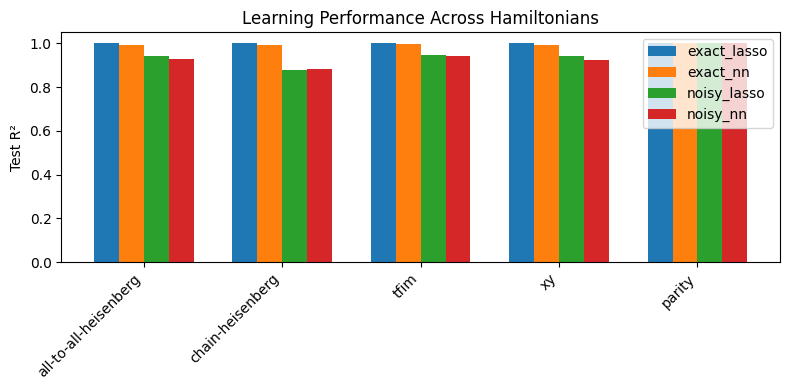

In [462]:
# Plot R^2 grouped bar chart
fig, ax = plt.subplots(figsize=(8,4))
hams    = df['hamiltonian'].unique()
methods = df['method'].unique()
x       = range(len(hams))
width   = 0.18

for i, method in enumerate(methods):
    vals = [df[(df.hamiltonian==h) & (df.method==method)]['r2_test'].item() for h in hams]
    ax.bar([xi + i*width for xi in x], vals, width, label=method)

ax.set_xticks([xi + (len(methods)-1)*width/2 for xi in x])
ax.set_xticklabels(hams, rotation=45, ha='right')
ax.set_ylabel("Test R\u00b2")
ax.set_title("Learning Performance Across Hamiltonians")
ax.legend()
plt.tight_layout()
plt.show()

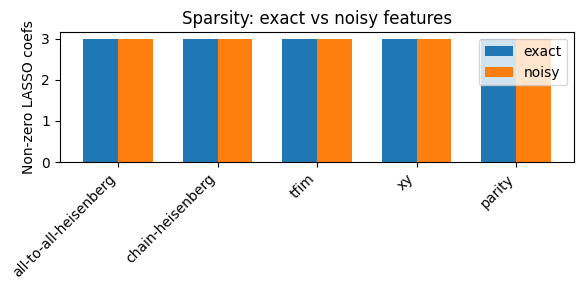

In [463]:
# bar-plot of LASSO sparsity

# Count non-zero LASSO coefs exact vs noisy
hams  = list(results_dict.keys())
exact = [(results_dict[h]['lasso_ex']['coef'] != 0).sum() for h in hams]
noisy = [(results_dict[h]['lasso_q']['coef'] != 0).sum() for h in hams]

# Plot
x = range(len(hams))
w = 0.35
fig, ax = plt.subplots(figsize=(6,3))
ax.bar([i - w/2 for i in x], exact, width=w, label='exact')
ax.bar([i + w/2 for i in x], noisy, width=w, label='noisy')
ax.set_xticks(x)
ax.set_xticklabels(hams, rotation=45, ha='right')
ax.set_ylabel('Non-zero LASSO coefs')
ax.set_title('Sparsity: exact vs noisy features')
ax.legend()
plt.tight_layout()
plt.show()

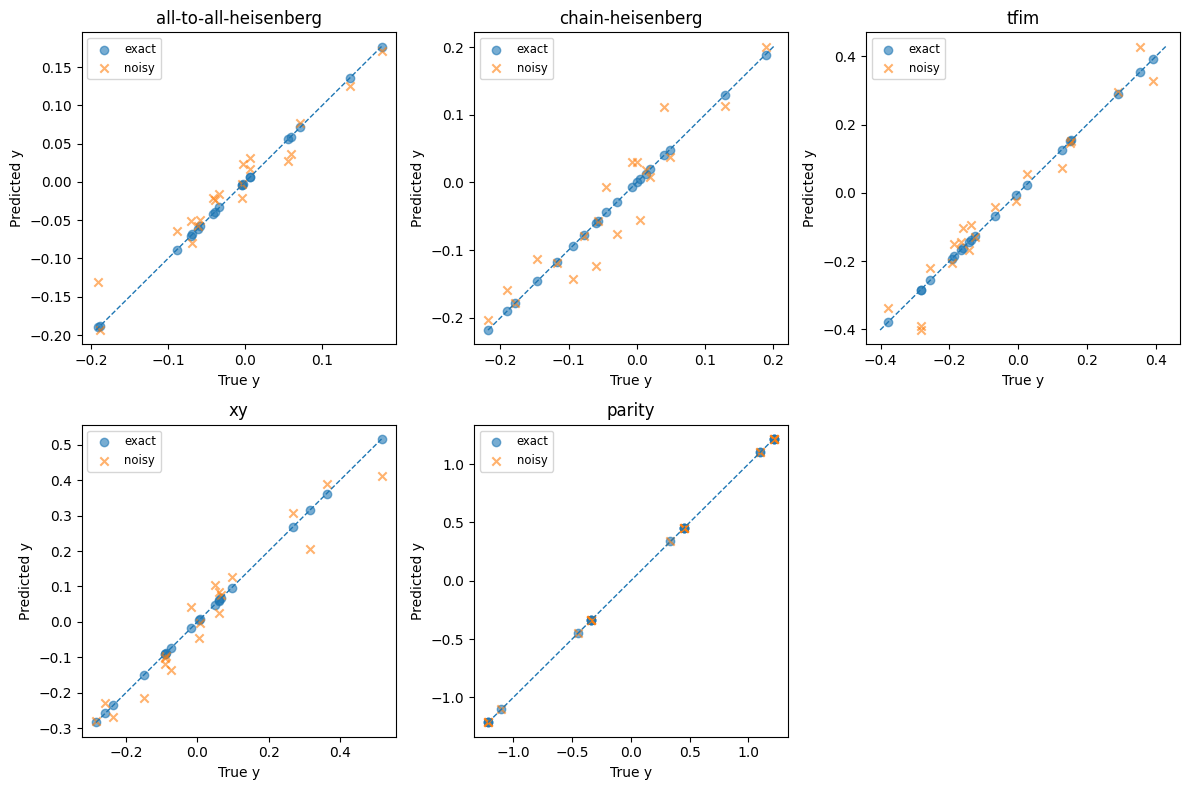

In [465]:
# scatter of predictions
# Create a 2x3 grid of scatter‐plots: True y vs Predicted y for exact vs noisy LASSO
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for ax, (name, res) in zip(axes, results_dict.items()):
    # exact LASSO
    y_test_ex  = res['lasso_ex']['y_test']
    y_pred_ex  = res['lasso_ex']['model'].predict(res['lasso_ex']['phi_test'])
    # noisy LASSO
    y_test_no  = res['lasso_q']['y_test']
    y_pred_no  = res['lasso_q']['model'].predict(res['lasso_q']['phi_test'])

    ax.scatter(y_test_ex, y_pred_ex, label='exact', alpha=0.6, marker='o')
    ax.scatter(y_test_no, y_pred_no, label='noisy', alpha=0.6, marker='x')

    # diagonal reference line
    mn = min(y_test_ex.min(), y_pred_no.min())
    mx = max(y_test_ex.max(), y_pred_no.max())
    ax.plot([mn, mx], [mn, mx], linestyle='--', linewidth=1)

    ax.set_title(name)
    ax.set_xlabel('True y')
    ax.set_ylabel('Predicted y')
    ax.legend(fontsize='small')

# turn off any unused subplot
if len(results_dict) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.show()
